# Authorization & Set-up

In [18]:
%pip install numba

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os

current_directory = os.getcwd()
%run packages.py #Download all required packages in one fell swoop. 

In [20]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

def getAuth():
    dotenv_path = '/Users/keegankelly/NYU/Classes/Advanced_Python/project/advanced_python/advanced_python.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  
    
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') 
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None
    

In [21]:
#Pull all user playlists for processing, specifically returning a dict of playlist ids & titles. 
def getPlaylistsid(access_token):
    user_id = os.environ.get("user_id")
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)

    if response.ok:
        playlists_json = response.json()
        playlist_info = [
            {"id": playlist["id"], "name": playlist["name"]}
            for playlist in playlists_json.get("items", [])
        ]
        return playlist_info
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None
    

In [22]:
#Creates a preliminary map of artist to genre, so we can link tracks>>artist>>genre. 
def genretoPlaylist(df_tracks, df_artists):
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

# Pulls all tracks from a list of playlists and returns a DataFrame with relevant track details. 
def getDfPlaylist(playlist_info, access_token):
    headers = {"Authorization": f"Bearer {access_token}"}

    def fetch_playlist(playlist_id):
        all_tracks = []
        url = f"{BASE_URL}playlists/{playlist_id}/tracks"
        while url:
            response = requests.get(url, headers=headers, params={"limit": 100})
            if response.ok:
                data = response.json()
                all_tracks.extend(data.get("items", []))
                url = data.get("next")
            else:
                print(f"Invalid {playlist_id}: {response.status_code}, {response.text}")
                return []
        return all_tracks

    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        results = executor.map(fetch_playlist, [info["id"] for info in playlist_info])

    all_tracks = list(itertools.chain.from_iterable(results))

    playlist_id_name_map = {info["id"]: info["name"] for info in playlist_info}

    tracks = []
    for item in all_tracks:
        track = item.get("track")
        if track:
            playlist_id = item.get("playlist_id")
            playlist_name = playlist_id_name_map.get(playlist_id, "Unknown")
            
            track_info = {
                "id": track.get("id"),
                "title": track.get("name"),
                "popularity": track.get("popularity"),
                "album": track["album"].get("name"),
                "release_date": track["album"].get("release_date"),
                "album_total_tracks": track["album"].get("total_tracks"),
                "artist": ', '.join([artist["name"] for artist in track["artists"]]), 
                "artist_id": track["artists"][0]["id"] if track["artists"] else None,  
                "album_id": track["album"].get("id"),
                "playlist_name": playlist_name
            }
            tracks.append(track_info)

    df_tracks = pd.DataFrame(tracks)
    
    return df_tracks

#Pulls relevant artists details. 
def getDfArtist(artist_ids, access_token):
    MAX_IDS = 50
    artists_info = []
    headers = {"Authorization": f"Bearer {access_token}"}
    
    # Batch requests to optimize network usage
    for i in range(0, len(artist_ids), MAX_IDS):
        chunk = artist_ids[i:i + MAX_IDS]
        artist_ids_str = ",".join(chunk)
        
        response = requests.get(f"{BASE_URL}artists?ids={artist_ids_str}", headers=headers)
        
        if response.ok:
            chunk_data = response.json()
            artists_info.extend(chunk_data.get("artists", []))
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
    
    artists = []
    for artist in artists_info:
        artist_info = {
            "followers": artist.get("followers", {}).get("total"),
            "genres": artist.get("genres", []),
            "id": artist.get("id"),
            "name": artist.get("name"),
            "popularity": artist.get("popularity"),
        }
        artists.append(artist_info)
    
    df_artists = pd.DataFrame(artists)
    return df_artists

#Notes:above ^ dedup artist prior reducing redundancy and unnecessary data processing.


In [23]:
# Pulls comprehensive audio details for input tracks.
def getDfAudioFeatures(track_ids, access_token):
    MAX_TRACKS = 100
    all_features = []  
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    for i in range(0, len(track_ids), MAX_TRACKS):
        chunk = track_ids[i:i+MAX_TRACKS]
        track_ids_str = ",".join(chunk)

        response = requests.get(f"{BASE_URL}audio-features?ids={track_ids_str}", headers=headers)
        if response.ok:
            data = response.json()
            all_features.extend(data.get('audio_features', []))
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
            return None  

    features_data = []
    for feature in all_features:
        if feature:  
            features = {
                'danceability': feature.get('danceability'),
                'energy': feature.get('energy'),
                'key': feature.get('key'),
                'loudness': feature.get('loudness'),
                'mode': feature.get('mode'),
                'speechiness': feature.get('speechiness'),
                'acousticness': feature.get('acousticness'),
                'instrumentalness': feature.get('instrumentalness'),
                'liveness': feature.get('liveness'),
                'valence': feature.get('valence'),
                'tempo': feature.get('tempo'),
                'duration_ms': feature.get('duration_ms'),
                'time_signature': feature.get('time_signature'),
                'id': feature.get('id')
            }
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

# Charts

In [24]:
def plotTopGenres(df_artists):
    all_genres = [genre for sublist in df_artists['genres'] if isinstance(sublist, list) for genre in sublist]
    genre_counts = pd.Series(all_genres).value_counts().nlargest(10)  #Get the top 10 genres.
    
    data = {
        'genres': genre_counts.index.tolist(),
        'counts': genre_counts.values
    }
    source = ColumnDataSource(data=data)
    
    p = figure(x_range=data['genres'], title="Top 10 Genres Based on Primary Genre of Artists",
               toolbar_location=None, tools="", height=400)
    
    hover = HoverTool()
    hover.tooltips = [
        ("Genre", "@genres"),
        ("Count", "@counts")
    ]
    p.add_tools(hover)
    
    p.vbar(x='genres', top='counts', width=0.9, source=source, fill_color='purple', line_color=None)
    
    p.xaxis.major_label_orientation = 1.2
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    output_notebook()
    show(p)

In [25]:
def wordCloud(df_artists):
    all_genres = ' '.join([genre for sublist in df_artists['genres'].dropna() for genre in sublist])
    
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white', 
                          colormap='inferno',  
                          min_font_size = 10).generate(all_genres)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [26]:
def plotPopularity(df_artists):
    bin_edges = np.arange(0, 105, 5)
    counts, _ = np.histogram(df_artists['popularity'], bins=bin_edges)
    percentages = (counts / df_artists['popularity'].count()) * 100
    avg_popularity = df_artists['popularity'].mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(bin_edges)-1), percentages, color='purple', edgecolor='black')
    for bar, count in zip(bars, counts):
        if count !=0:
            ax.annotate(f'{count}', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xticks(range(len(bin_edges)-1))
    ax.set_xticklabels([f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)], rotation=45, ha="right")

    ax.set_xlabel('Popularity Score Range')
    ax.set_ylabel('Percentage of Artists')
    ax.set_title('Overall Playlist Popularity')

    caption = f"How unique is your taste? This playlist's average popularity score is roughly {avg_popularity:.1f}"
    fig.text(0.5, 0.01, caption, ha='center', va='bottom', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

In [27]:
def plotgenreDiversity(df_artists):
    all_genres = set()
    for genres in df_artists['genres']:
        all_genres.update(genres)
    total_unique_genres = len(all_genres)
    
    # Prep data for the top 10 artists by genre count.
    df_artists['genre_count'] = df_artists['genres'].apply(len)
    top_artists = df_artists.nlargest(10, 'genre_count')
    
    source = ColumnDataSource(data=dict(
        names=top_artists['name'],
        counts=top_artists['genre_count'],
        genres=['; '.join(genres) for genres in top_artists['genres']]
    ))
    
    p = figure(x_range=top_artists['name'], height=400, title="Top 10 Artists by Genre Diversity",
               toolbar_location=None, tools="")
    p.vbar(x='names', top='counts', width=0.9, source=source, legend_field="names", 
           line_color='white', fill_color='purple')
    
    p.add_tools(HoverTool(tooltips=[("Artist", "@names"), ("# Genres", "@counts"), ("Genres", "@genres")]))
    
    p.xaxis.major_label_orientation = "vertical"
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    caption_text = f'<div><strong>Total Unique Genres in Playlist: {total_unique_genres}</strong></div>'
    caption = Div(text=caption_text)
    layout = column(p, caption)
    
    output_notebook() 
    show(layout)

In [28]:
def plotRelease(df_tracks):
    #filter out poorly formatted dates
    df_tracks = df_tracks[df_tracks['release_date'].str.len()==10]
    df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year
    tracks_by_year = df_tracks['release_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    tracks_by_year.plot(kind='bar', color='purple', edgecolor='black') 
    plt.xlabel('Year of Release')
    plt.ylabel('Number of Songs')
    plt.title('Songs by Year of Release')
    plt.xticks(rotation=45)
    plt.show()

In [29]:
def plotTopofPlaylist(df_tracks, artists_df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

    top_5_songs = df_tracks.sort_values(ascending=False, by='popularity')[:5]
    axs[0].bar(top_5_songs['title'], top_5_songs['popularity'], color='purple', width=0.5)
    axs[0].set_title('Top 5 Most Popular Songs in Playlist')
    axs[0].set_xlabel('Song Title')
    axs[0].set_ylabel('Popularity')
    axs[0].tick_params(axis='x', rotation=90)

    top_5_artists = artists_df.sort_values(ascending=False, by='popularity')[:5]
    axs[1].bar(top_5_artists['name'], top_5_artists['popularity'], color='purple', width=0.4)
    axs[1].set_title('Top 5 Spotify Artists in Playlist')
    axs[1].set_xlabel('Artist')
    axs[1].set_ylabel('Popularity')
    
    plt.tight_layout()
    plt.show()

In [30]:
def plotAudioFeatures(df_audio_features):
    features = ['danceability', 'energy', 'liveness']
    data = [df_audio_features[feature] for feature in features]
    
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    # plt.style.use('seaborn-deep')

    ax1.hist(data, bins=20, label=features)
    ax1.set_xlabel("Scale")
    ax1.set_ylabel("Frequency")
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    
    box = ax2.boxplot(data, vert=False, positions=np.arange(len(data)) + 1, patch_artist=True)
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(1, len(data) + 1))
    ax2.set_yticklabels(features)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel("Features")

    plt.title("Audio Features Distributions")
    plt.show()

In [31]:
def plotDuration(df_audio_features):
    plt.hist(df_audio_features.duration_ms, color='purple', rwidth=0.7)
    plt.xlabel("Song Duration")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Song Duration Distribution")
    plt.show()

In [32]:
def plotTempo(df_audio_features):
    plt.figure(figsize=(10, 6))
    plt.hist(df_audio_features['tempo'], bins=30, color='purple', edgecolor='black')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of Songs')
    plt.title('Frequency of Song Tempos')
    plt.show()

# Testing

In [33]:
def playlist_analyzer():
    access_token = getAuth()
    playlist_info = getPlaylistsid(access_token)
    df_tracks = getDfPlaylist(playlist_info, access_token)

    unique_artist_ids = df_tracks["artist_id"].drop_duplicates().tolist()
    df_artists = getDfArtist(unique_artist_ids, access_token)
    df_tracks_updated = genretoPlaylist(df_tracks, df_artists)

    unique_track_ids = df_tracks["id"].tolist()
    df_audio_features = getDfAudioFeatures(unique_track_ids, access_token)

    plotTopGenres(df_artists)
    wordCloud(df_artists)
    plotPopularity(df_artists)
    plotgenreDiversity(df_artists)
    plotRelease(df_tracks_updated)
    plotTopofPlaylist(df_tracks_updated, df_artists)
    plotAudioFeatures(df_audio_features)
    plotDuration(df_audio_features)
    plotTempo(df_audio_features)

# t = time.process_time()
# playlist_analyzer()
# elapsed_time = time.process_time() - t
# print('Time elapsed:', elapsed_time,'s')

Loading BokehJS ...

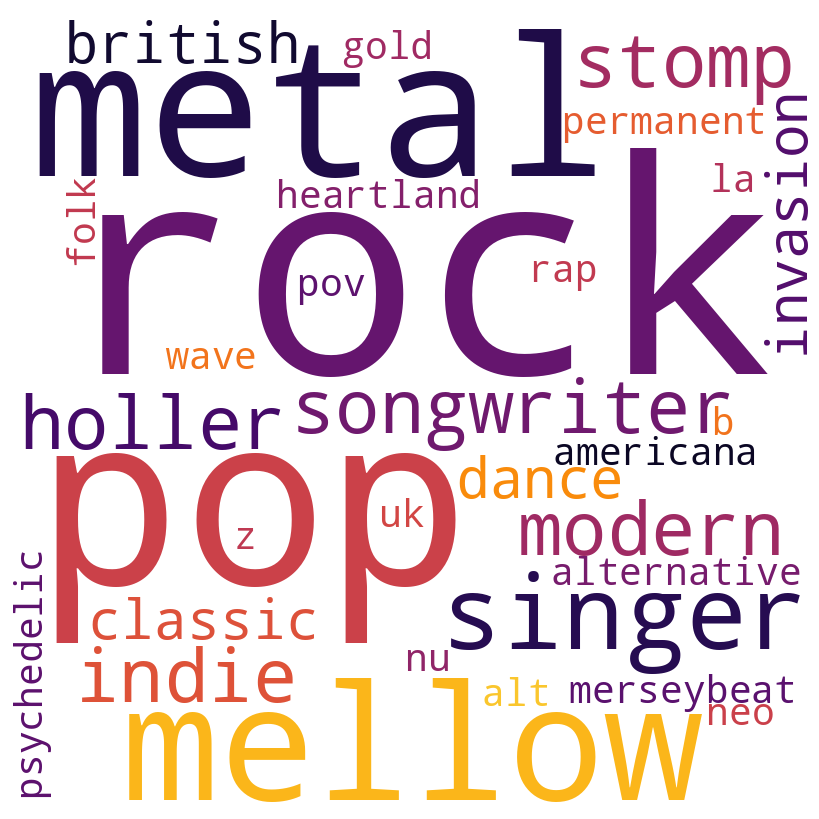

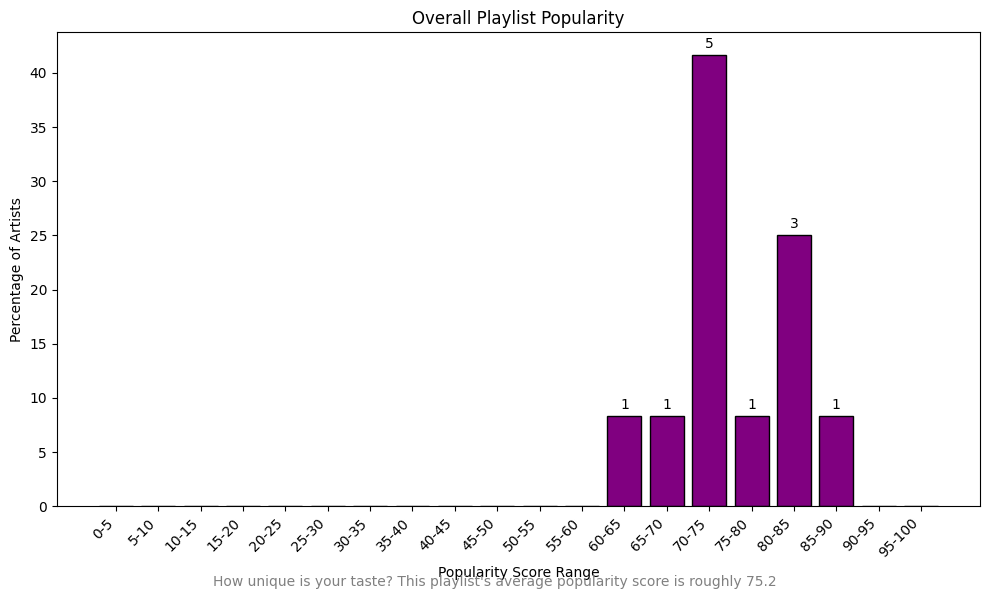

Loading BokehJS ...

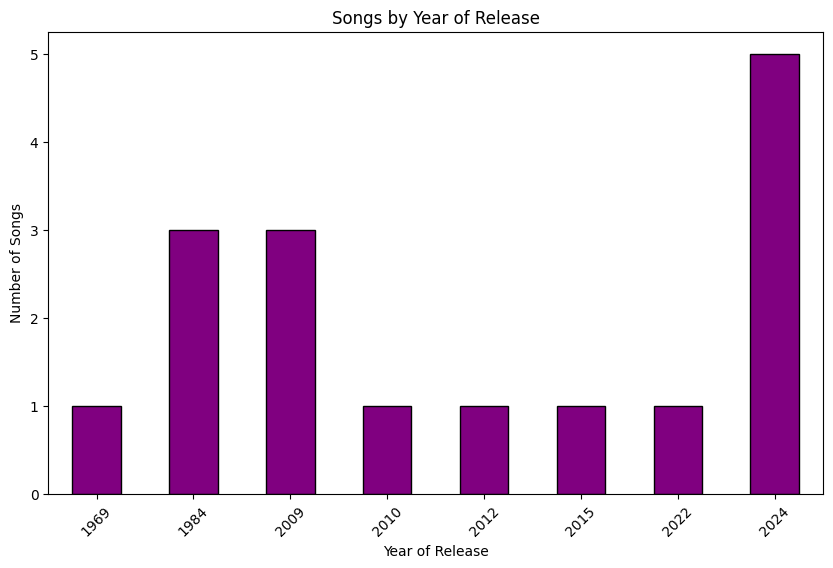

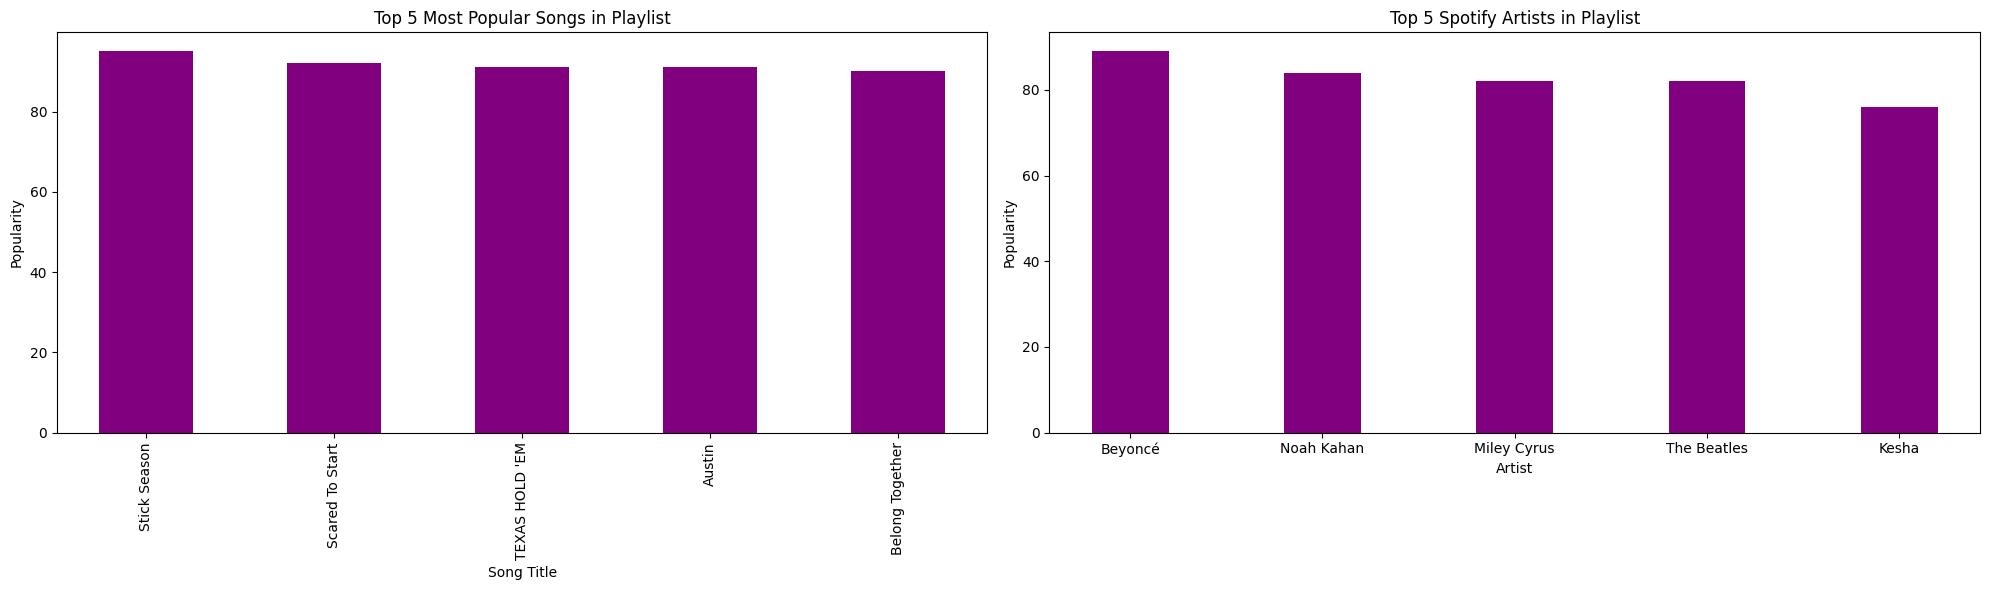

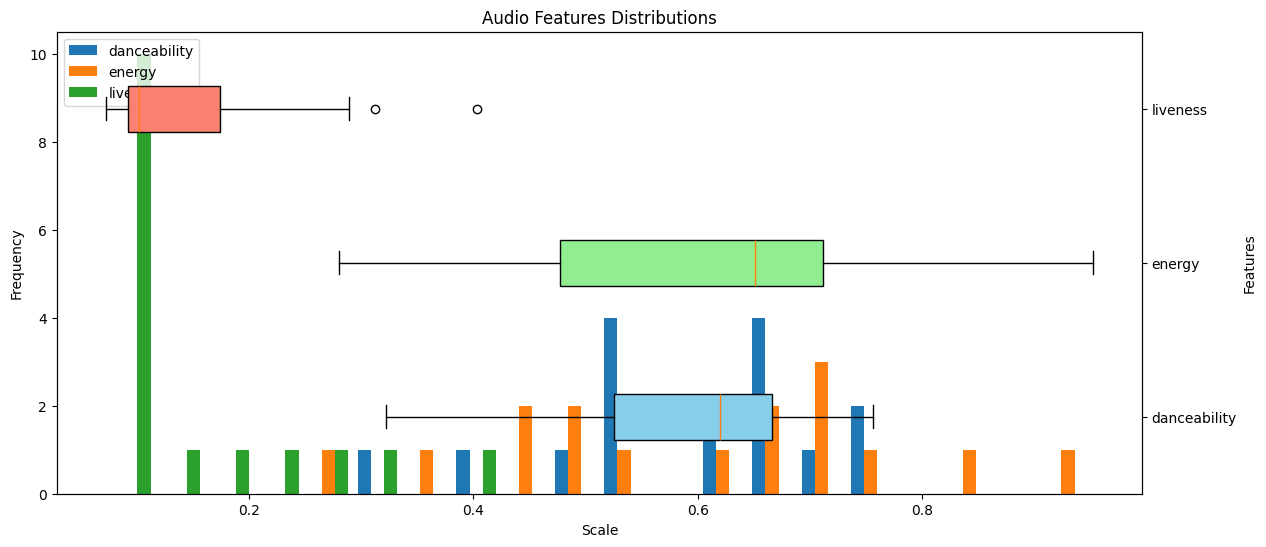

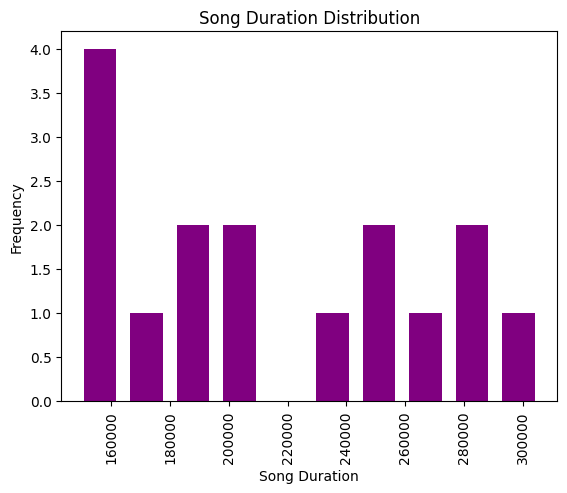

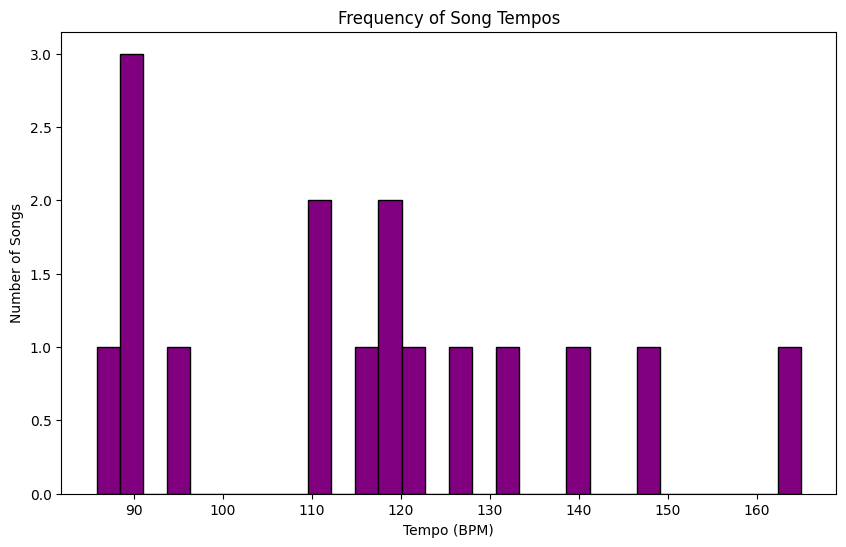

Loading BokehJS ...

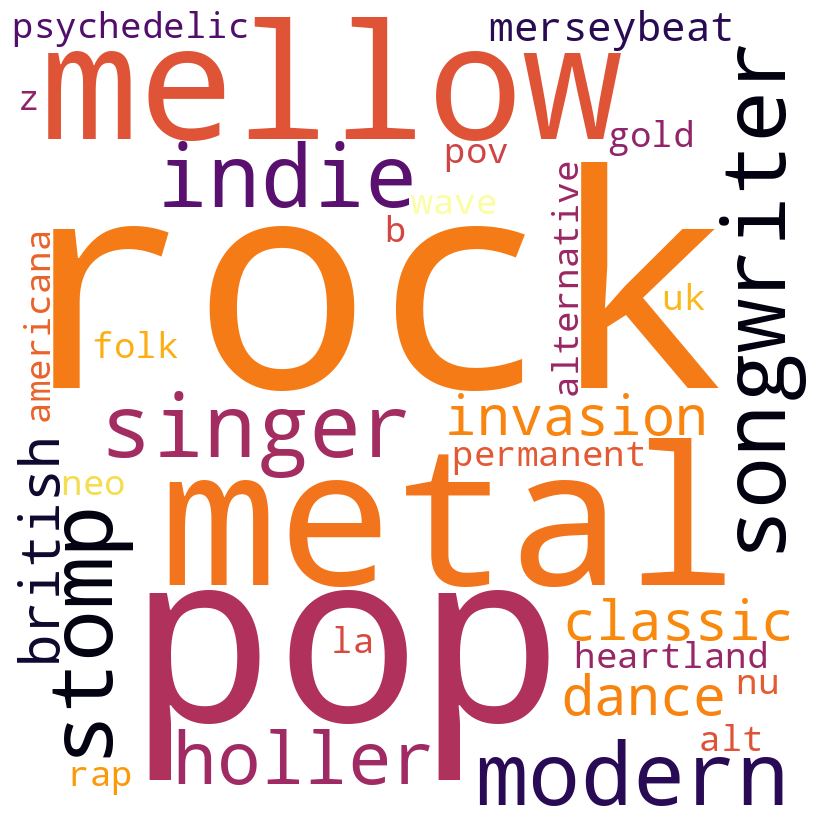

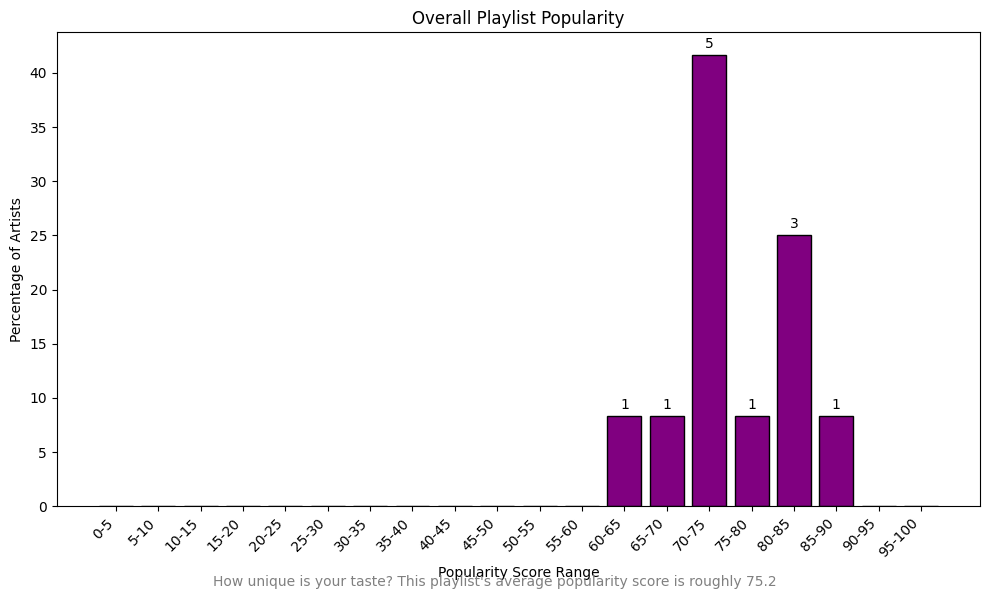

Loading BokehJS ...

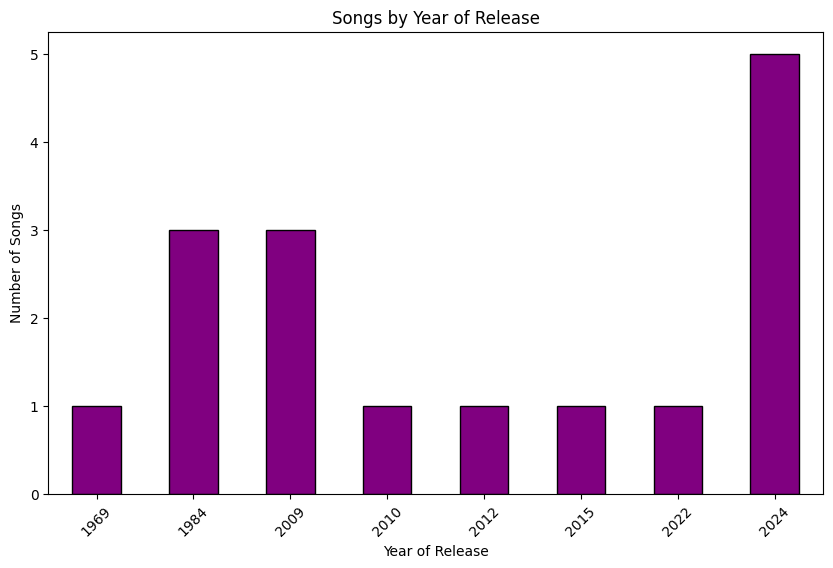

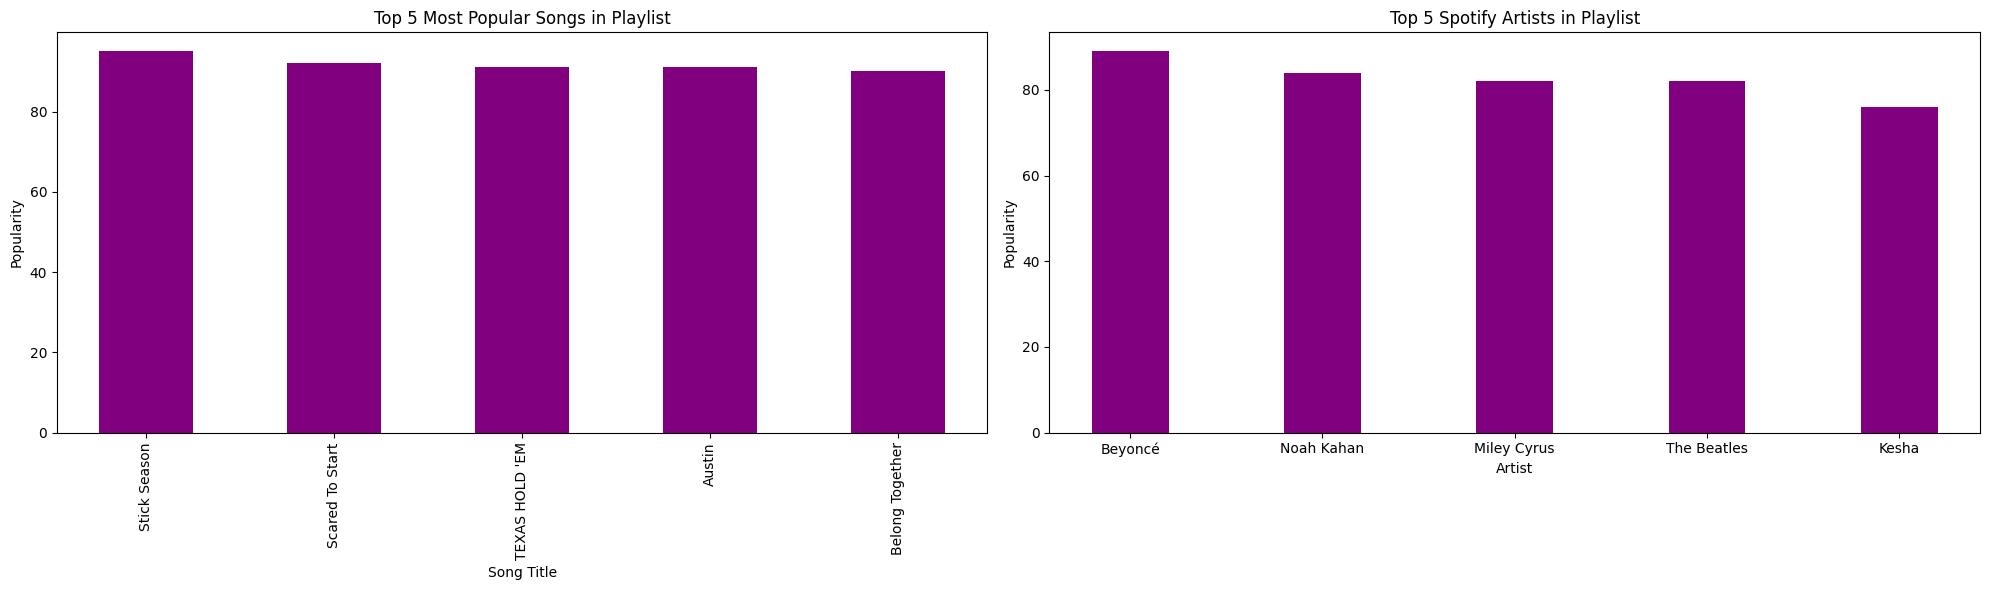

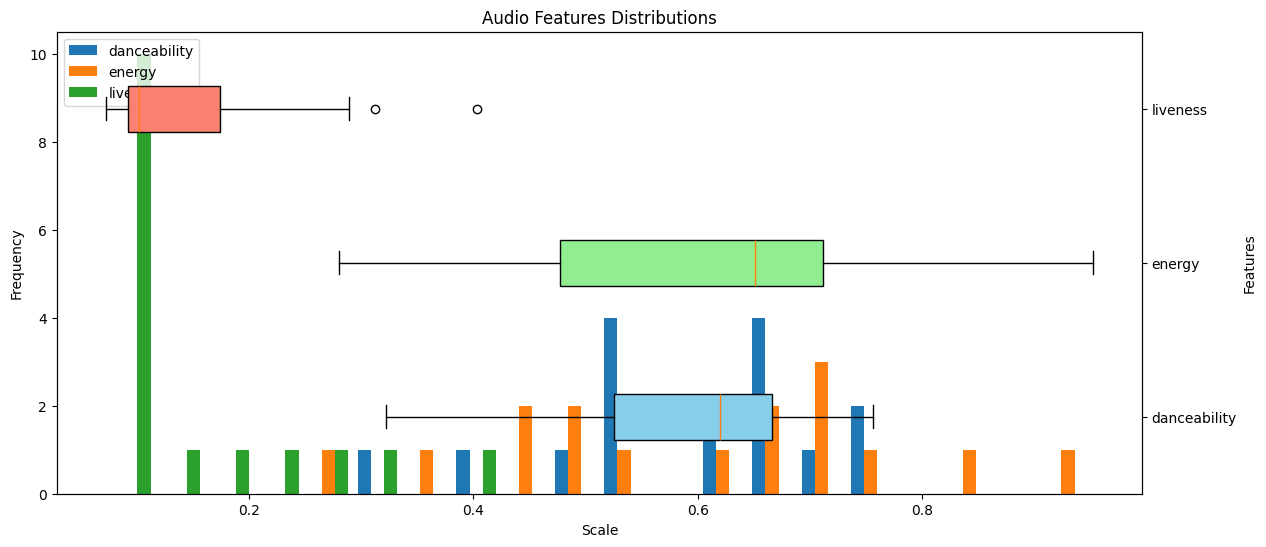

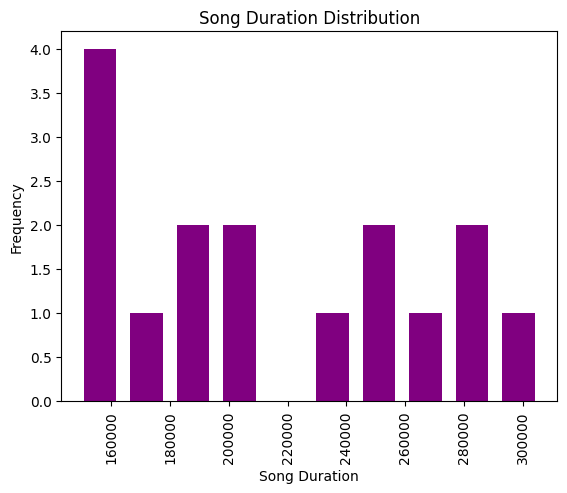

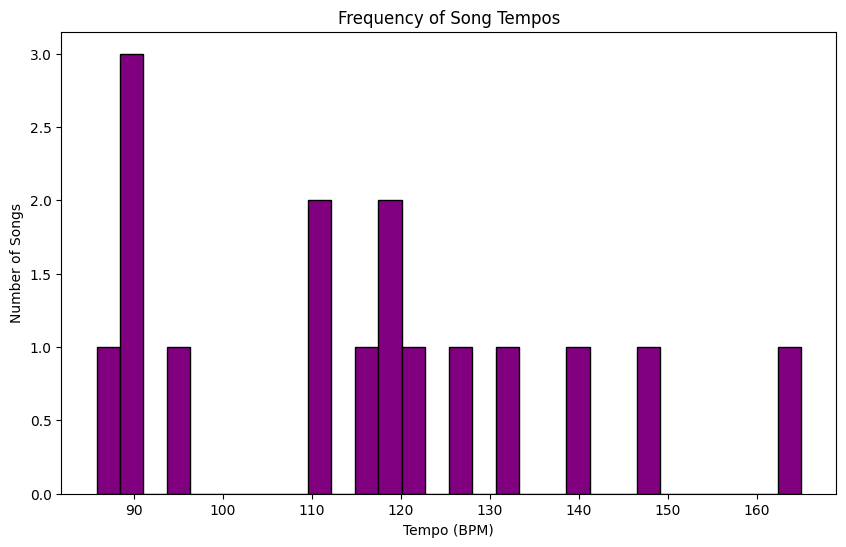

Loading BokehJS ...

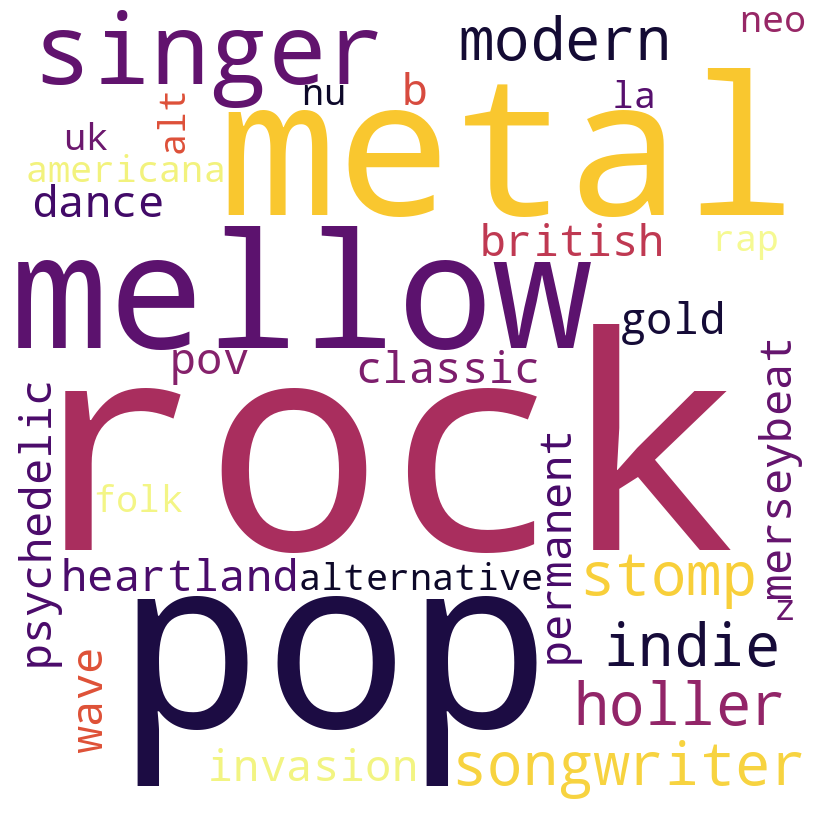

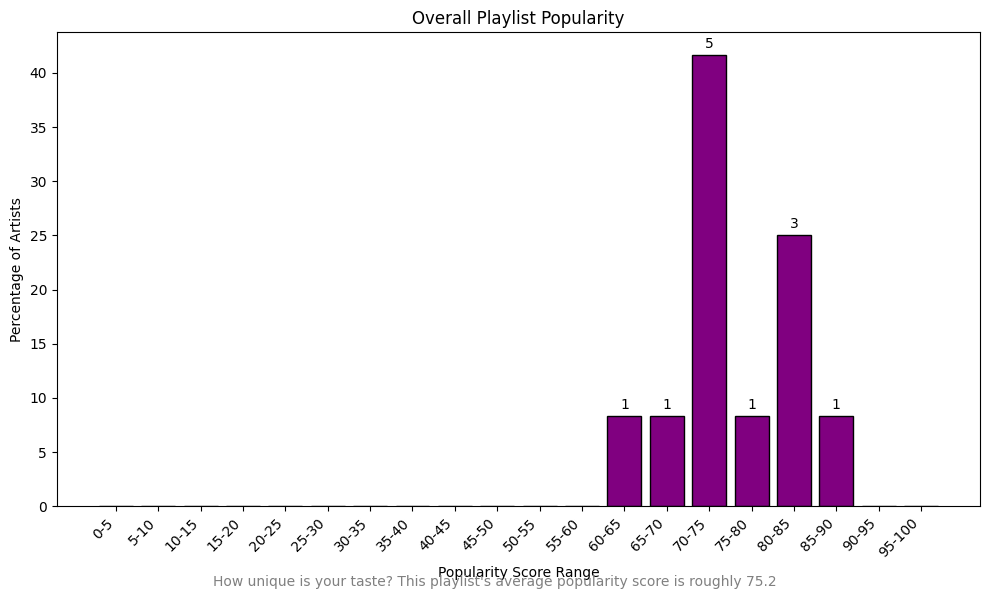

Loading BokehJS ...

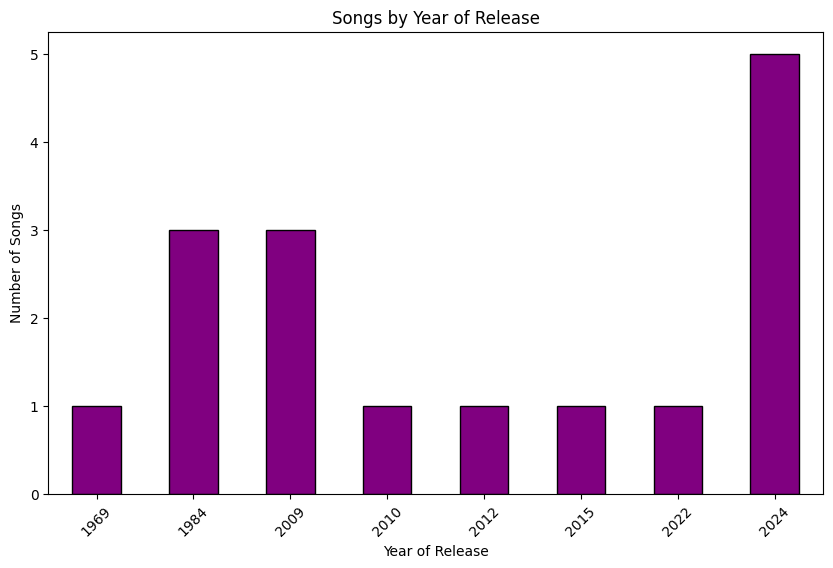

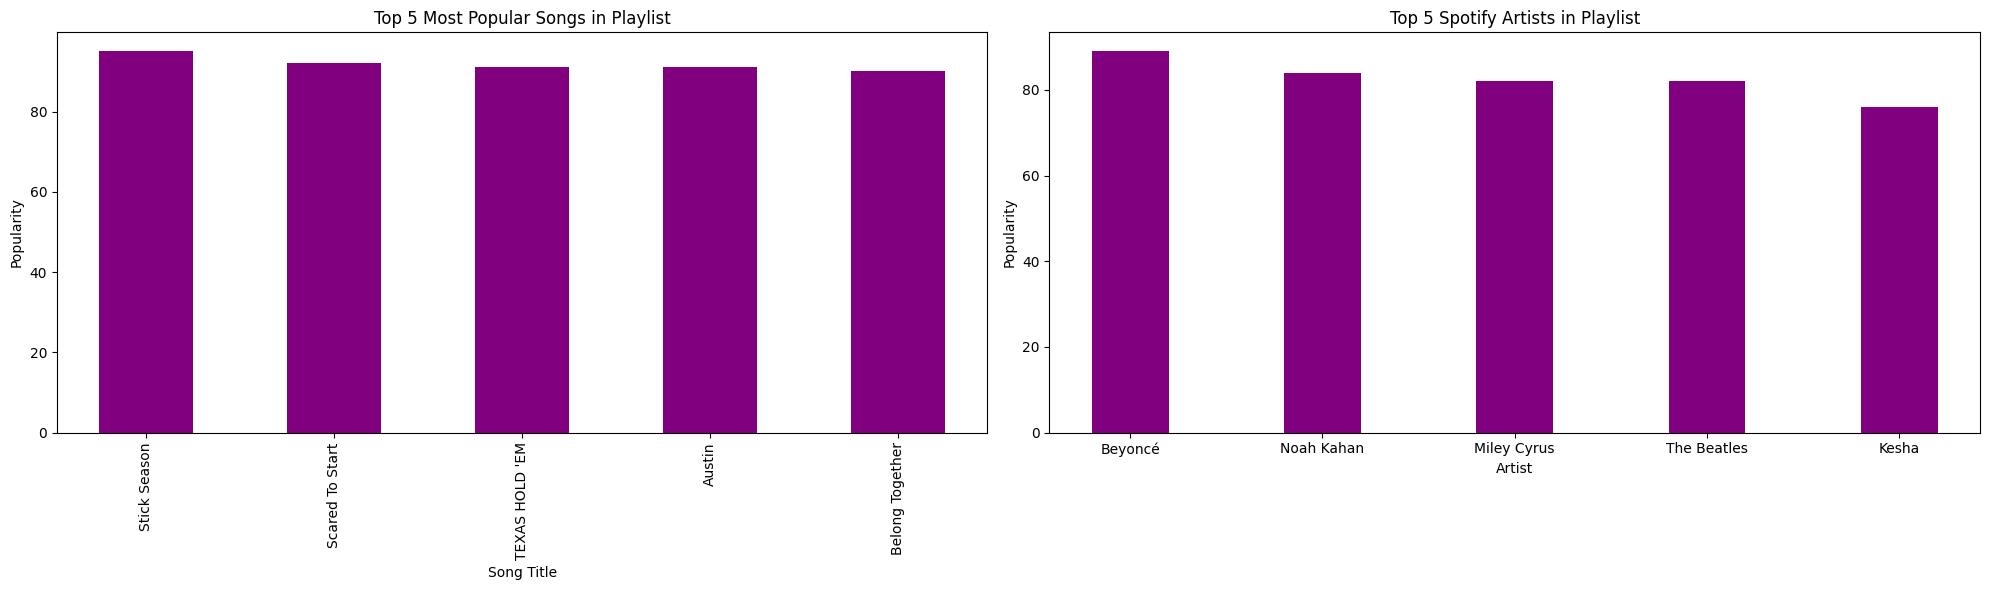

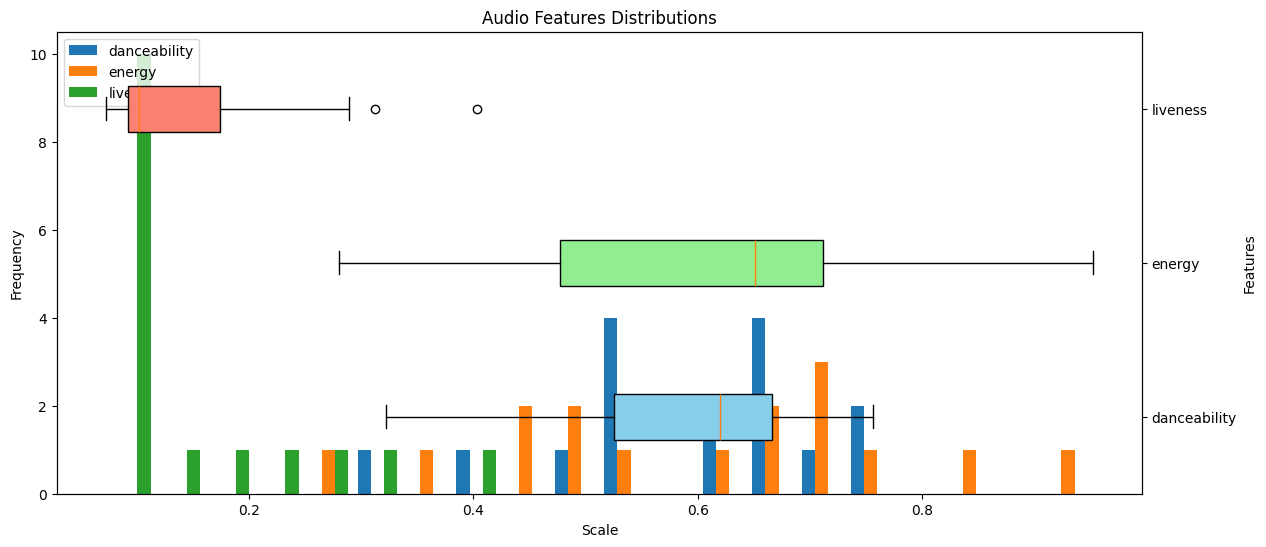

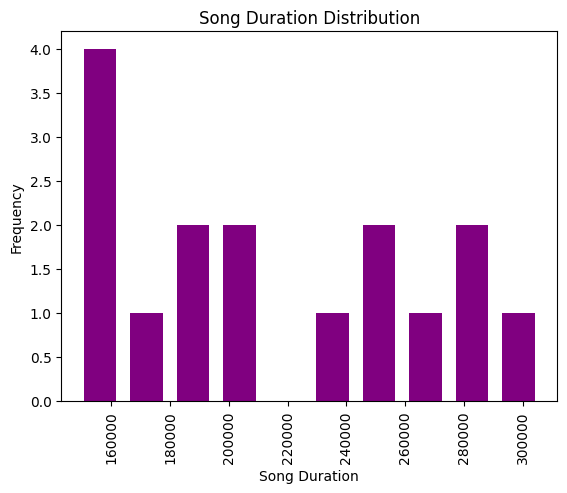

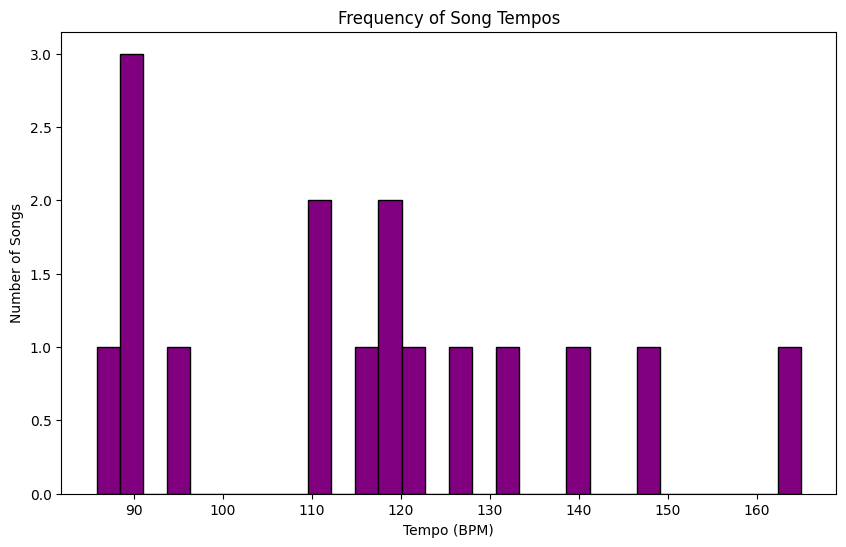

Loading BokehJS ...

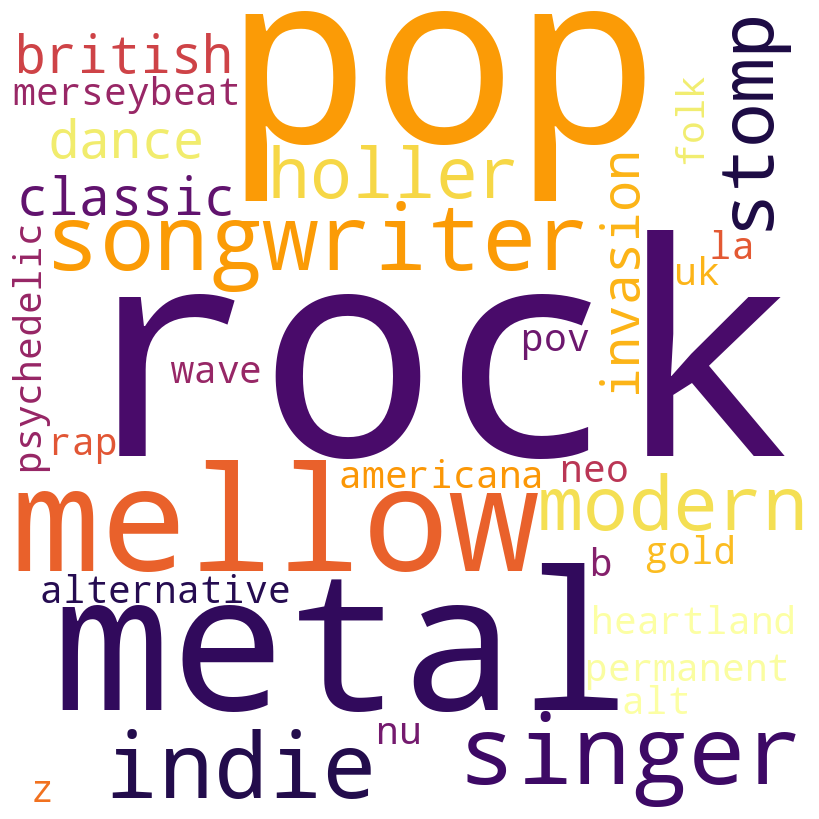

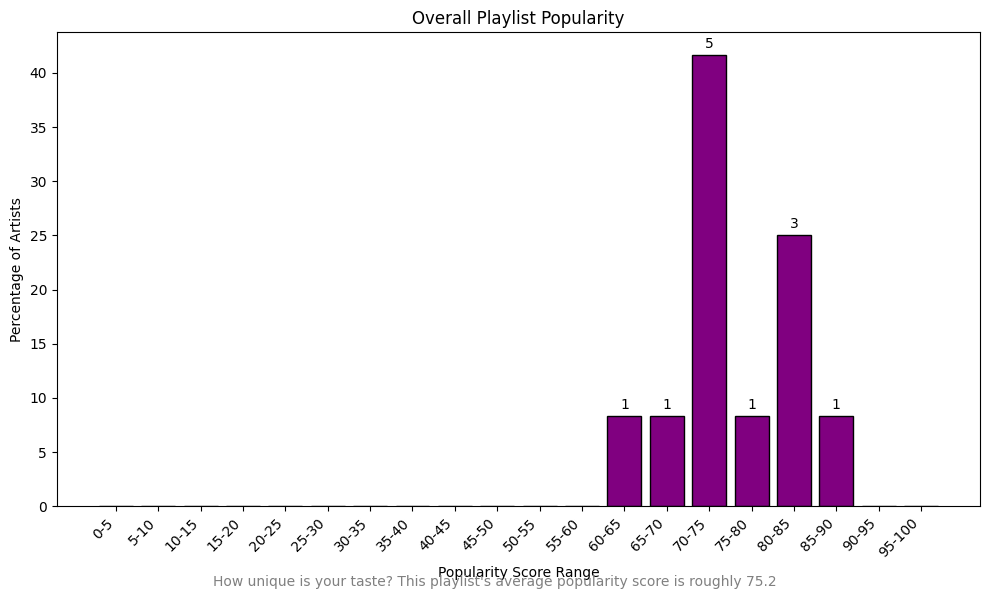

Loading BokehJS ...

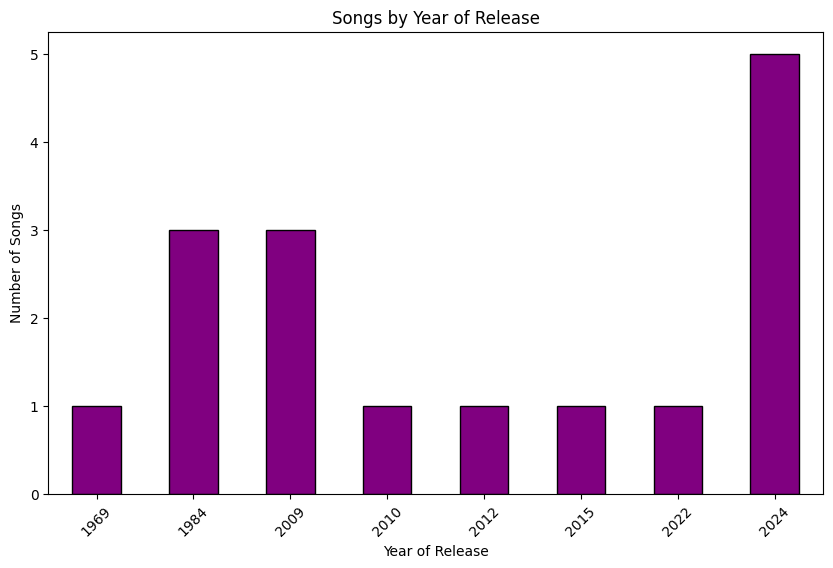

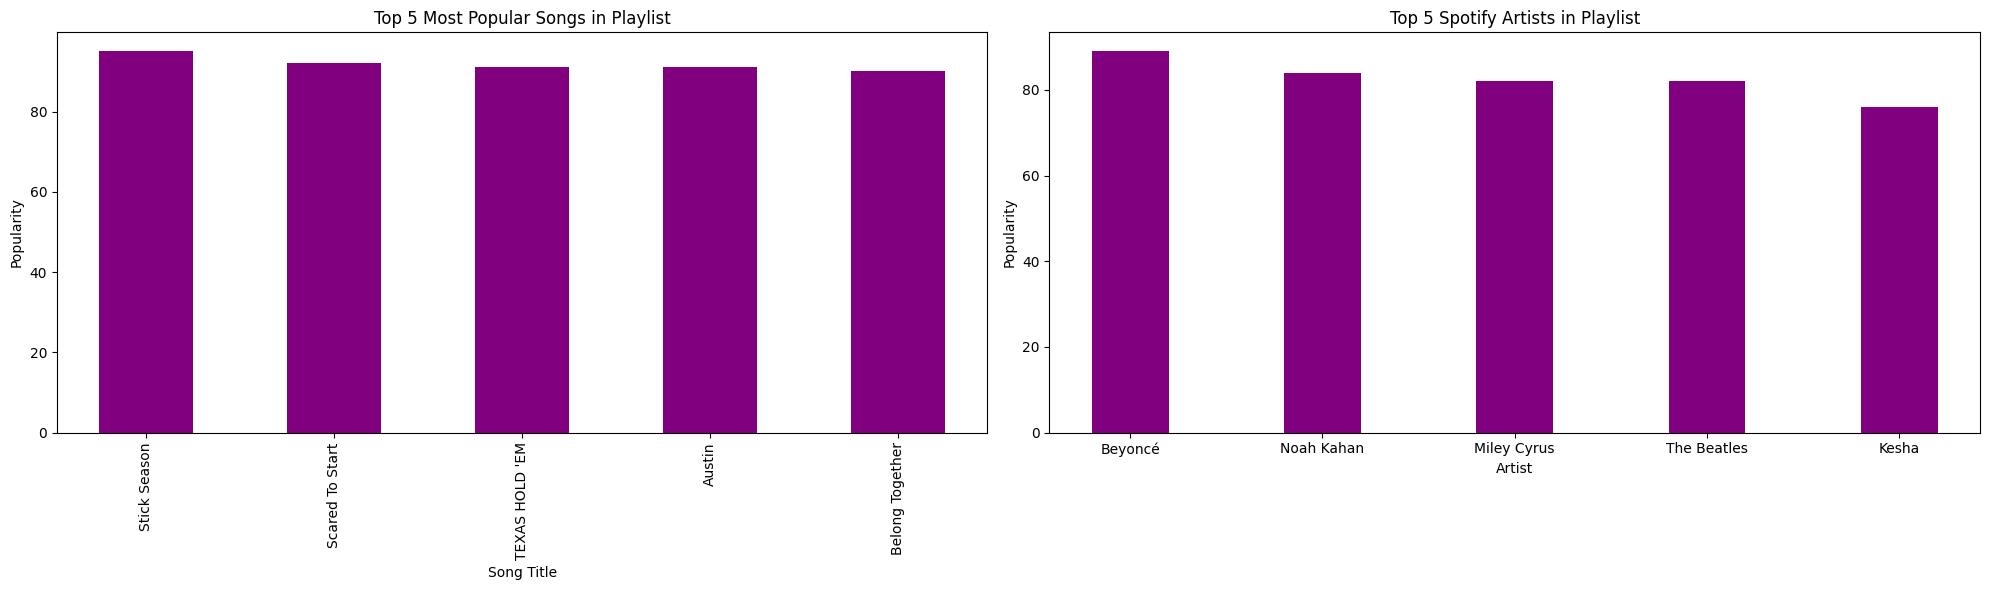

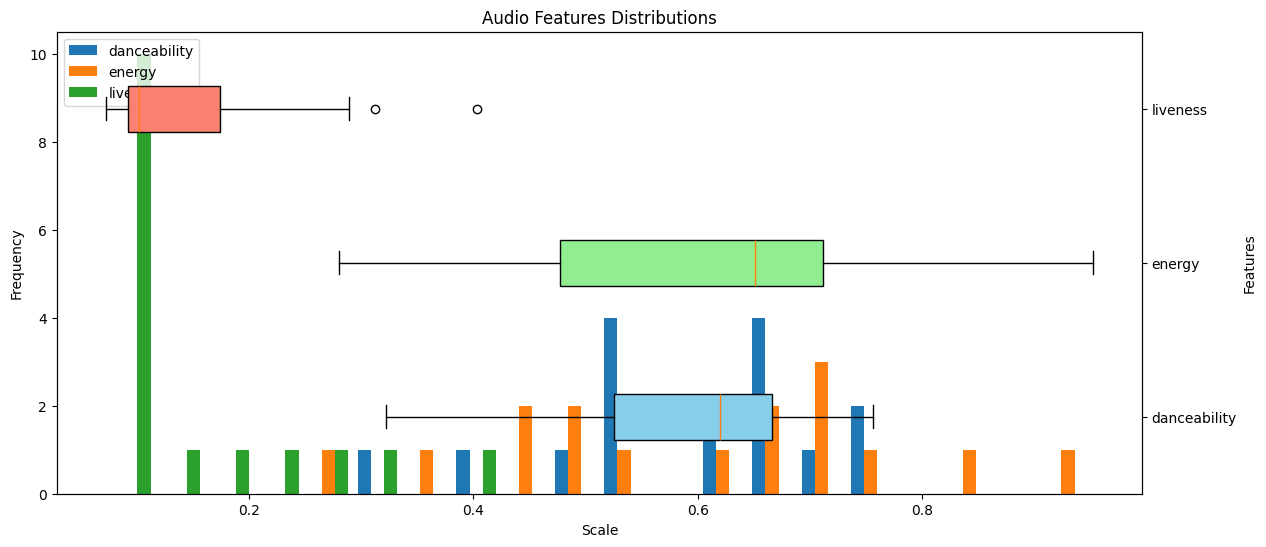

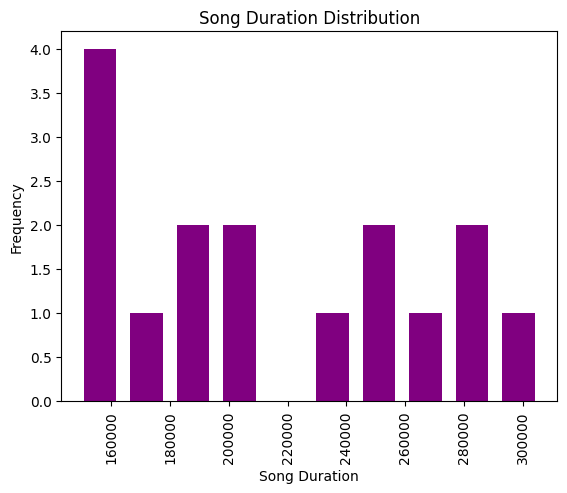

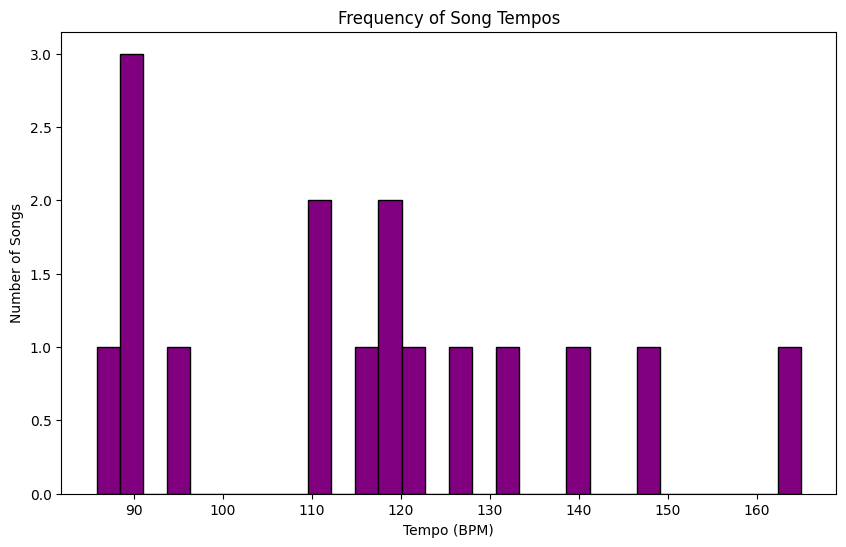

Loading BokehJS ...

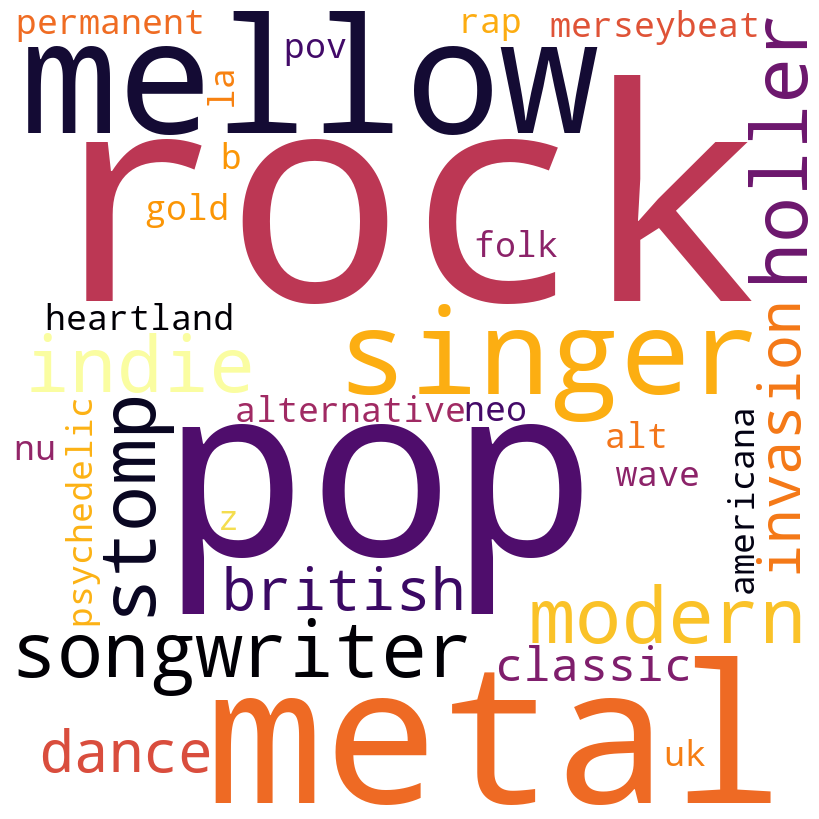

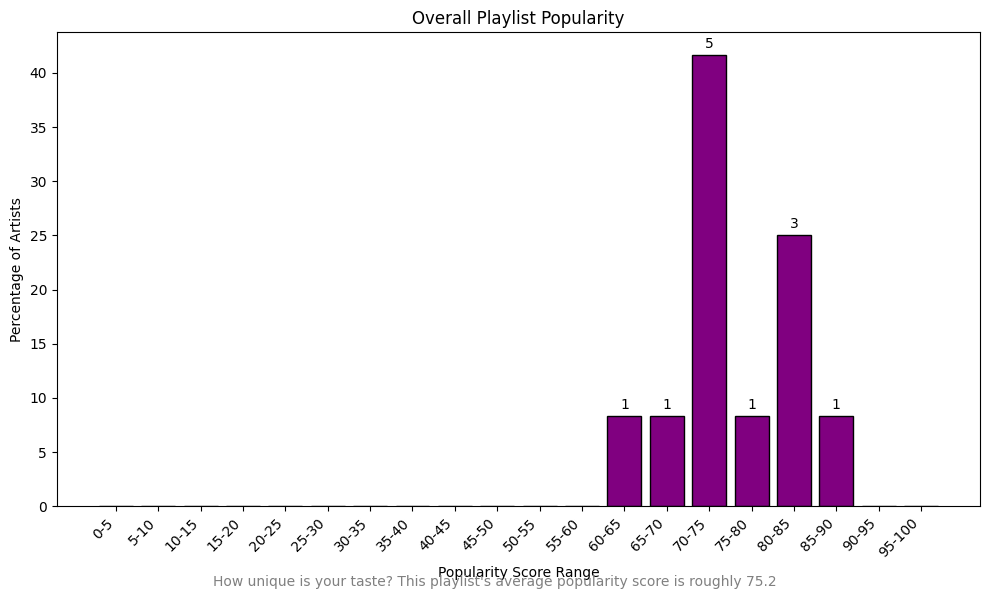

Loading BokehJS ...

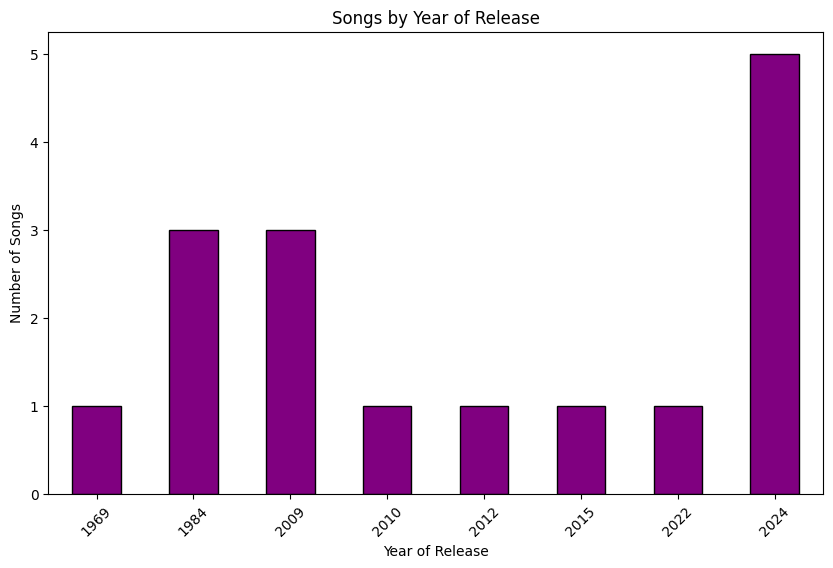

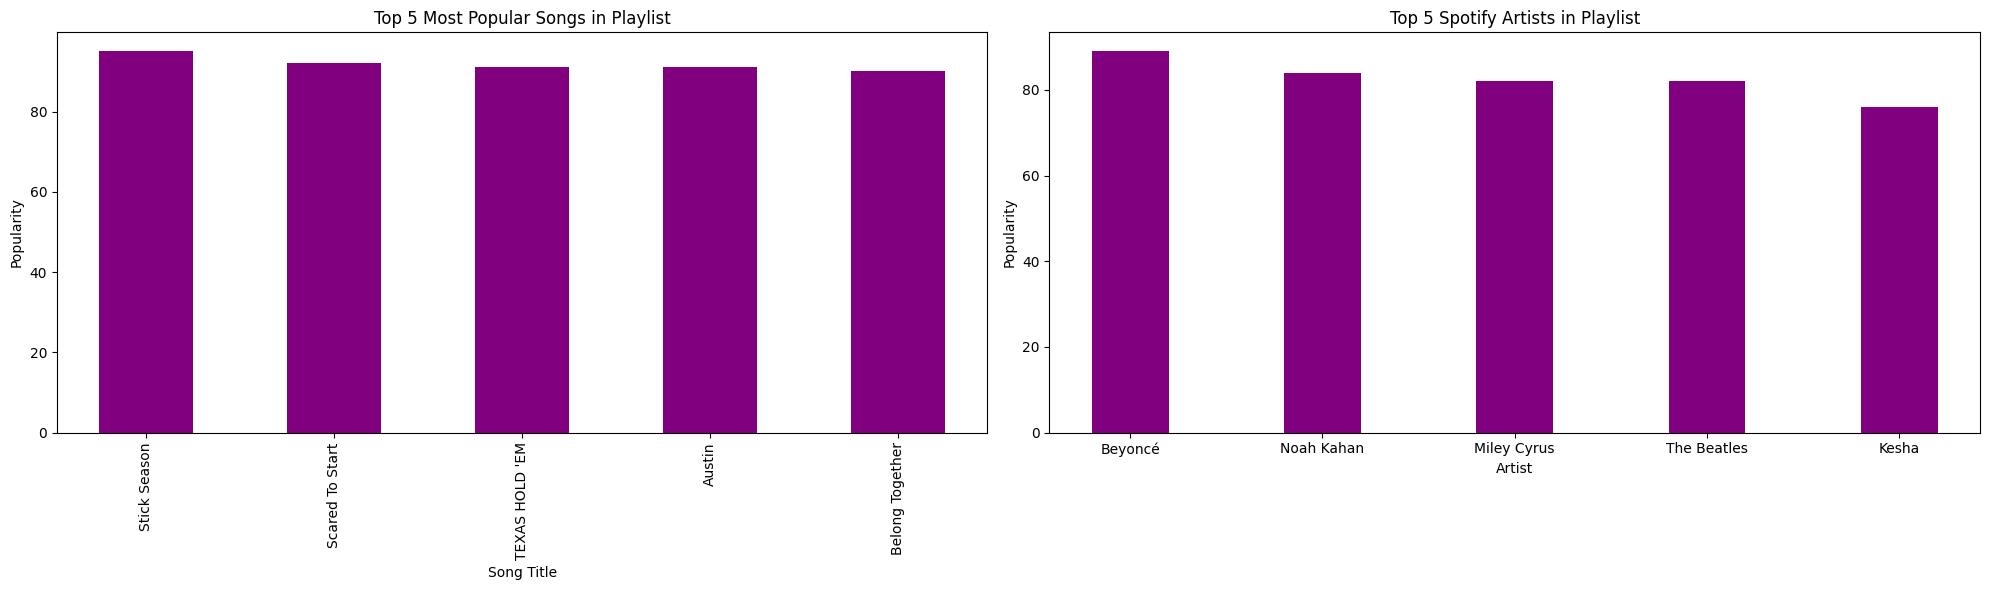

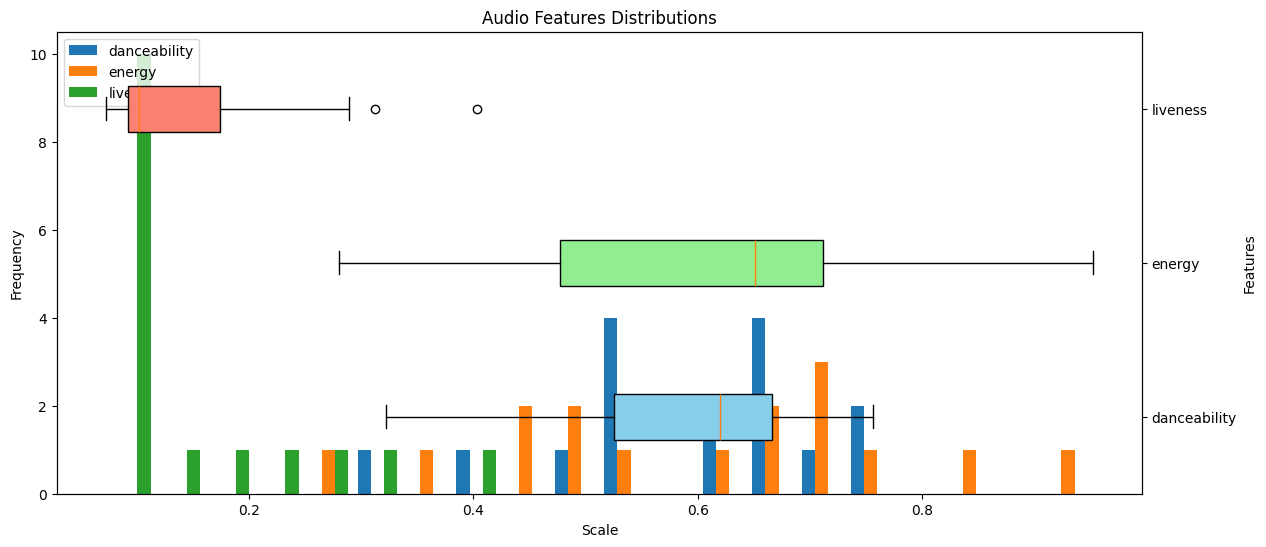

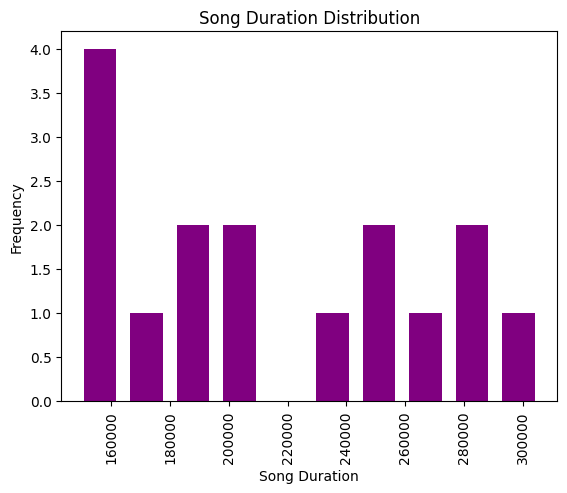

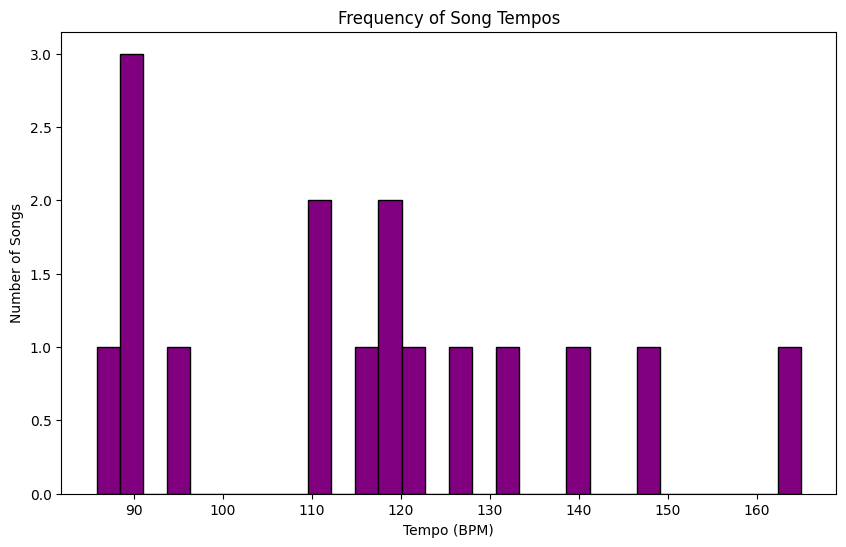

Loading BokehJS ...

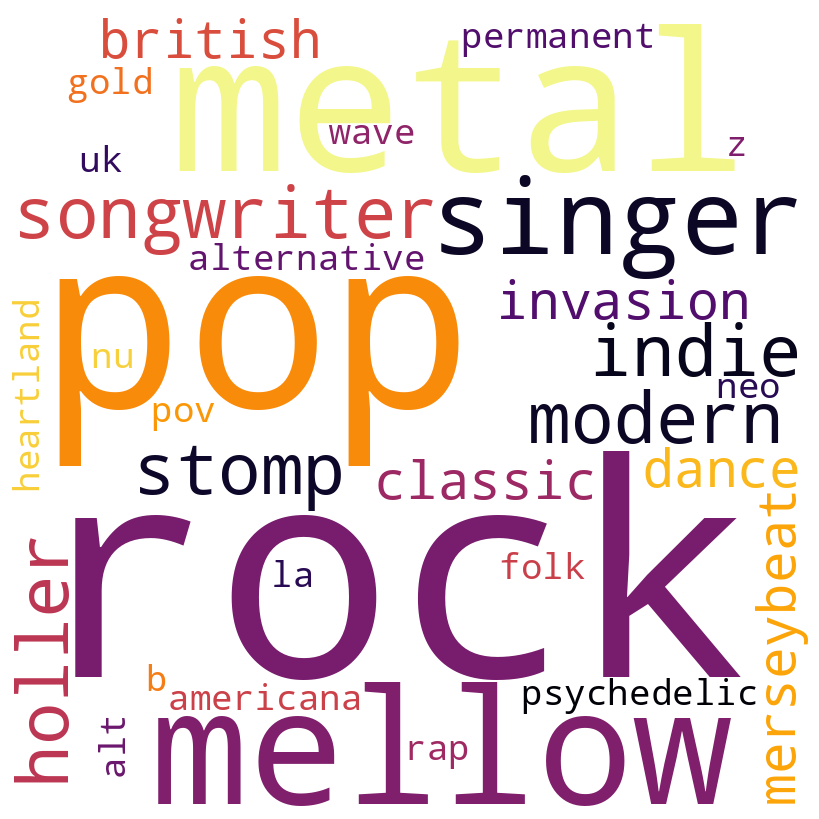

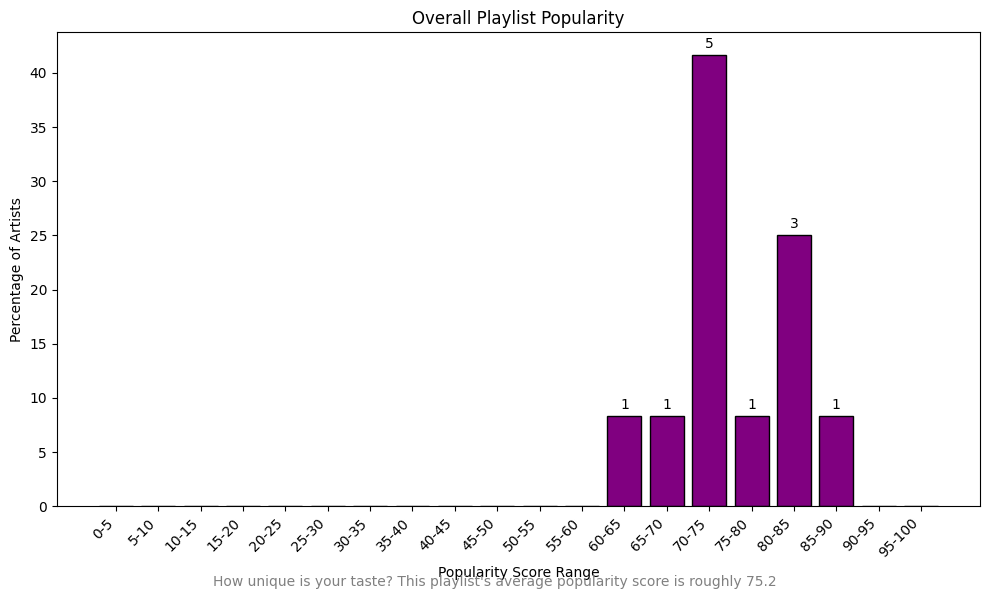

Loading BokehJS ...

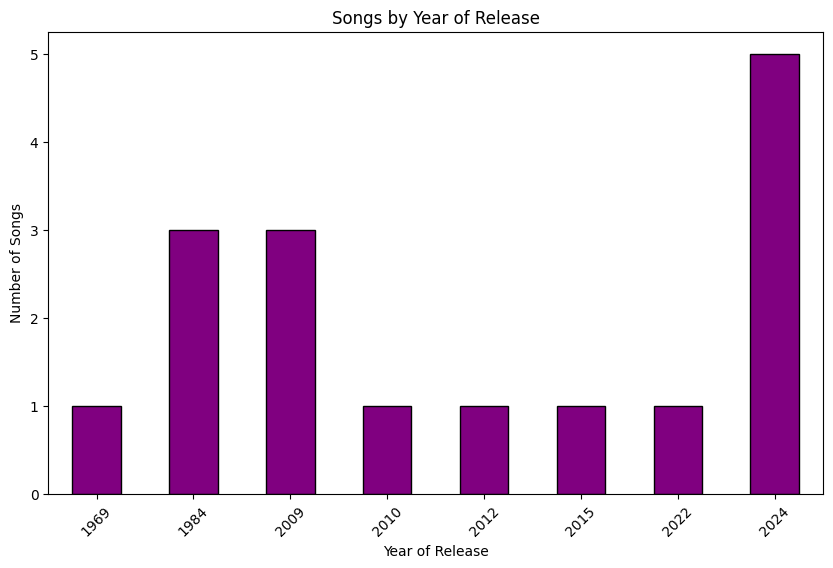

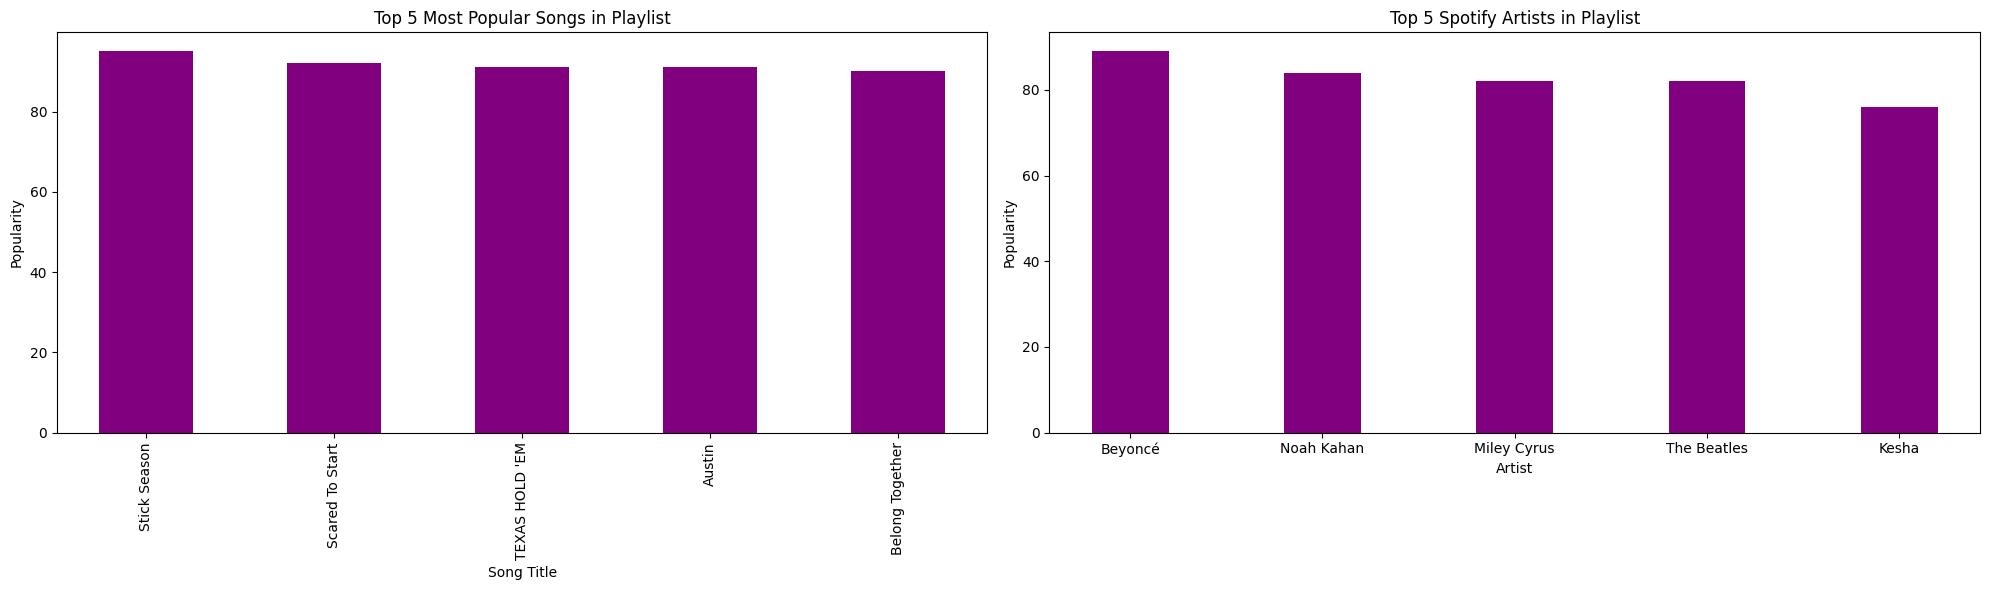

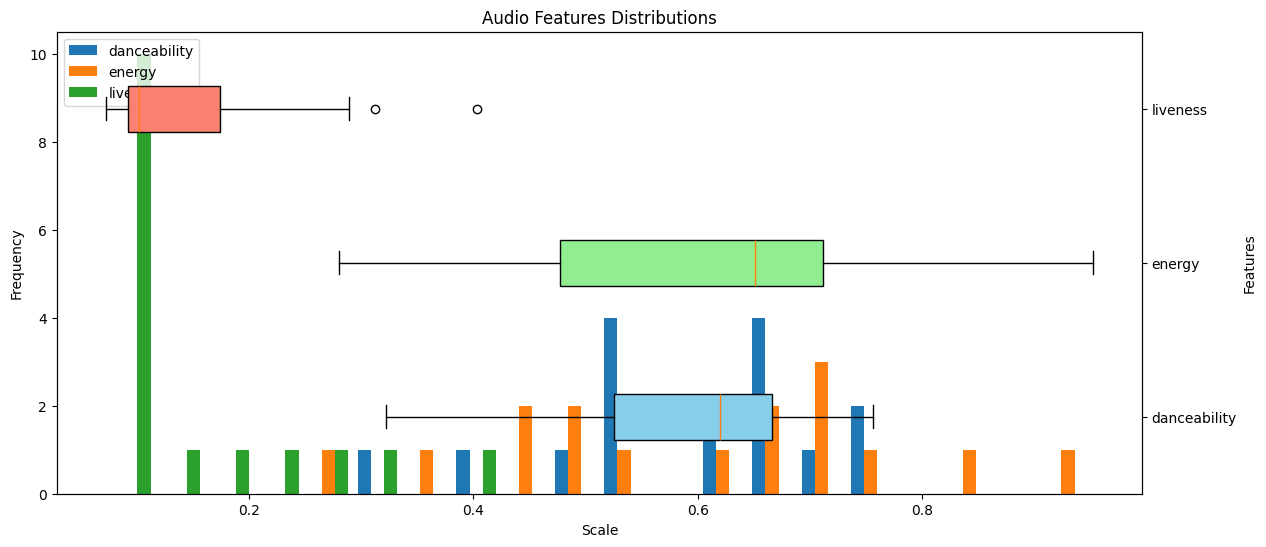

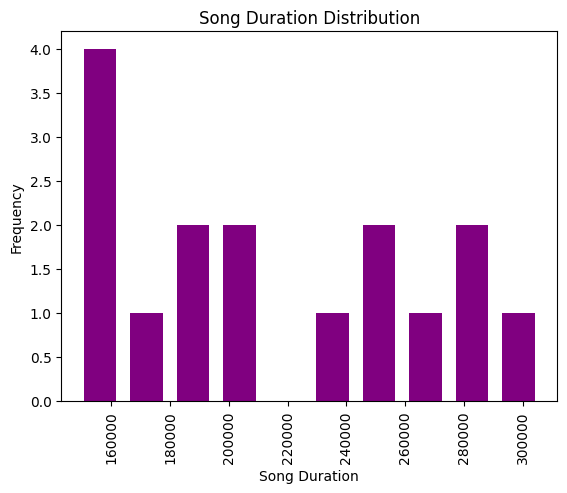

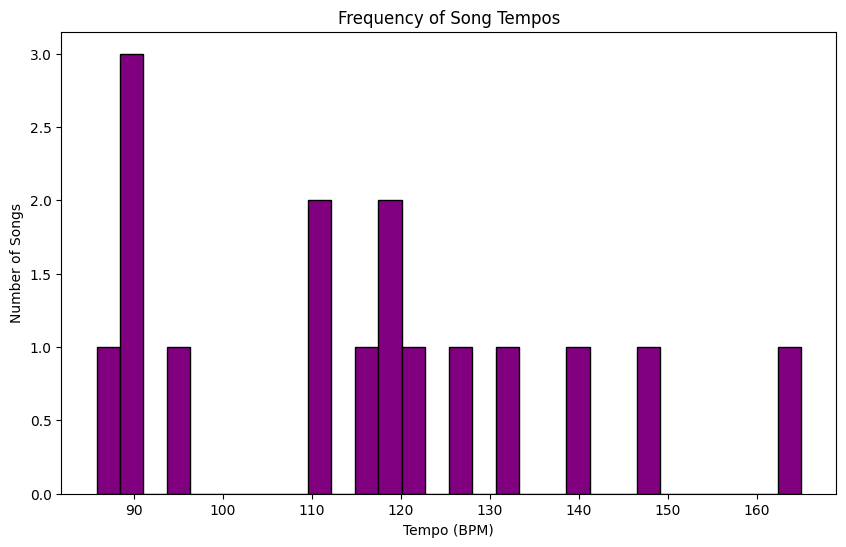

Loading BokehJS ...

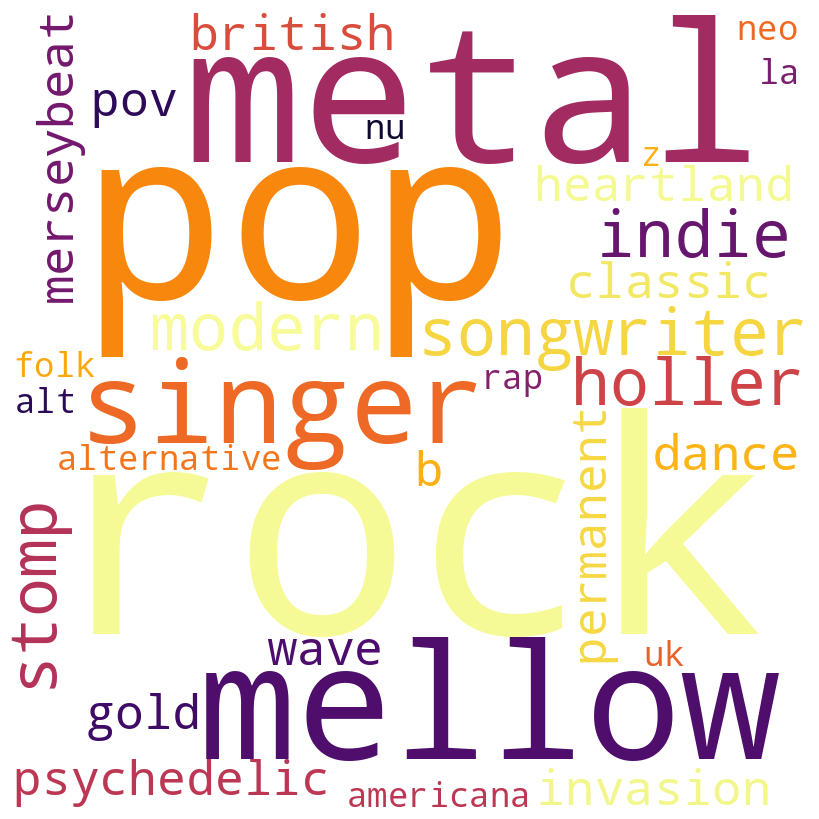

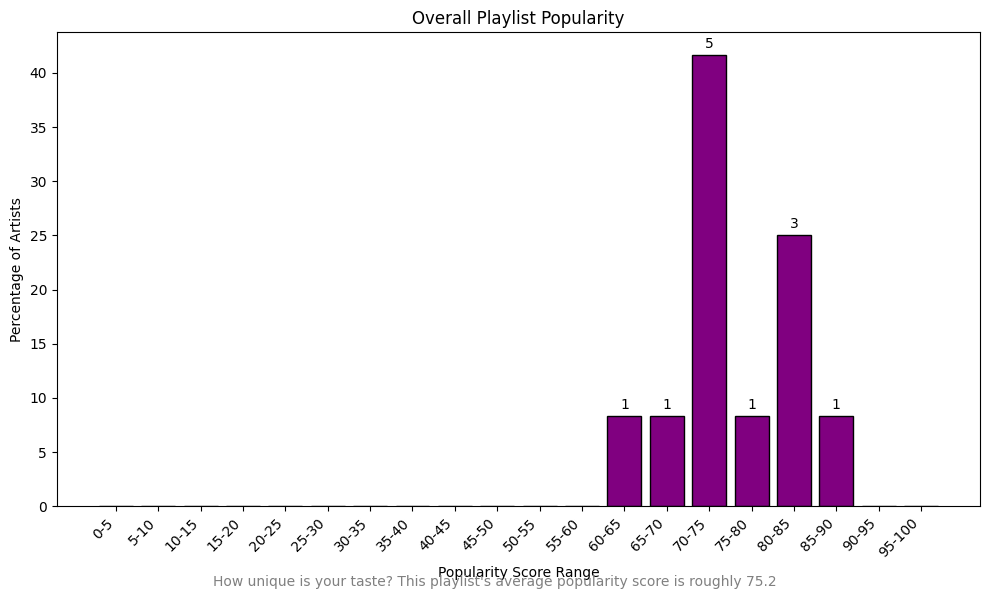

Loading BokehJS ...

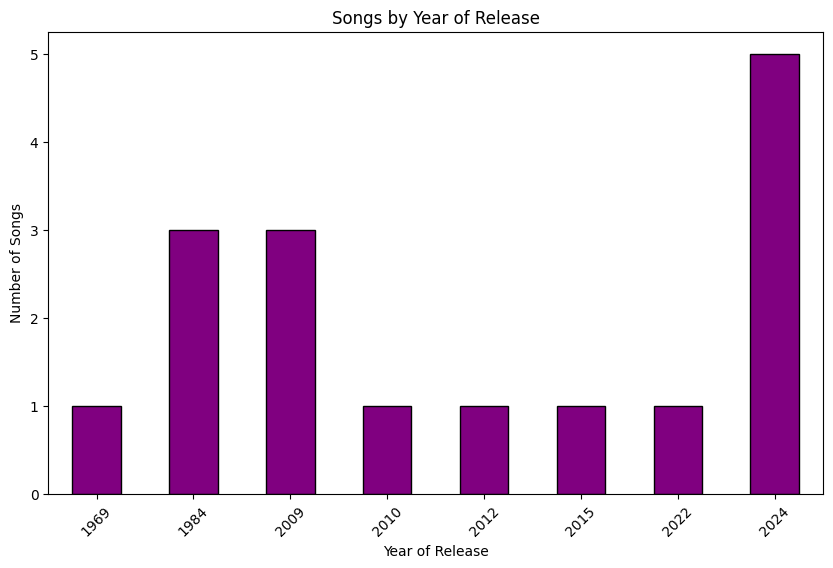

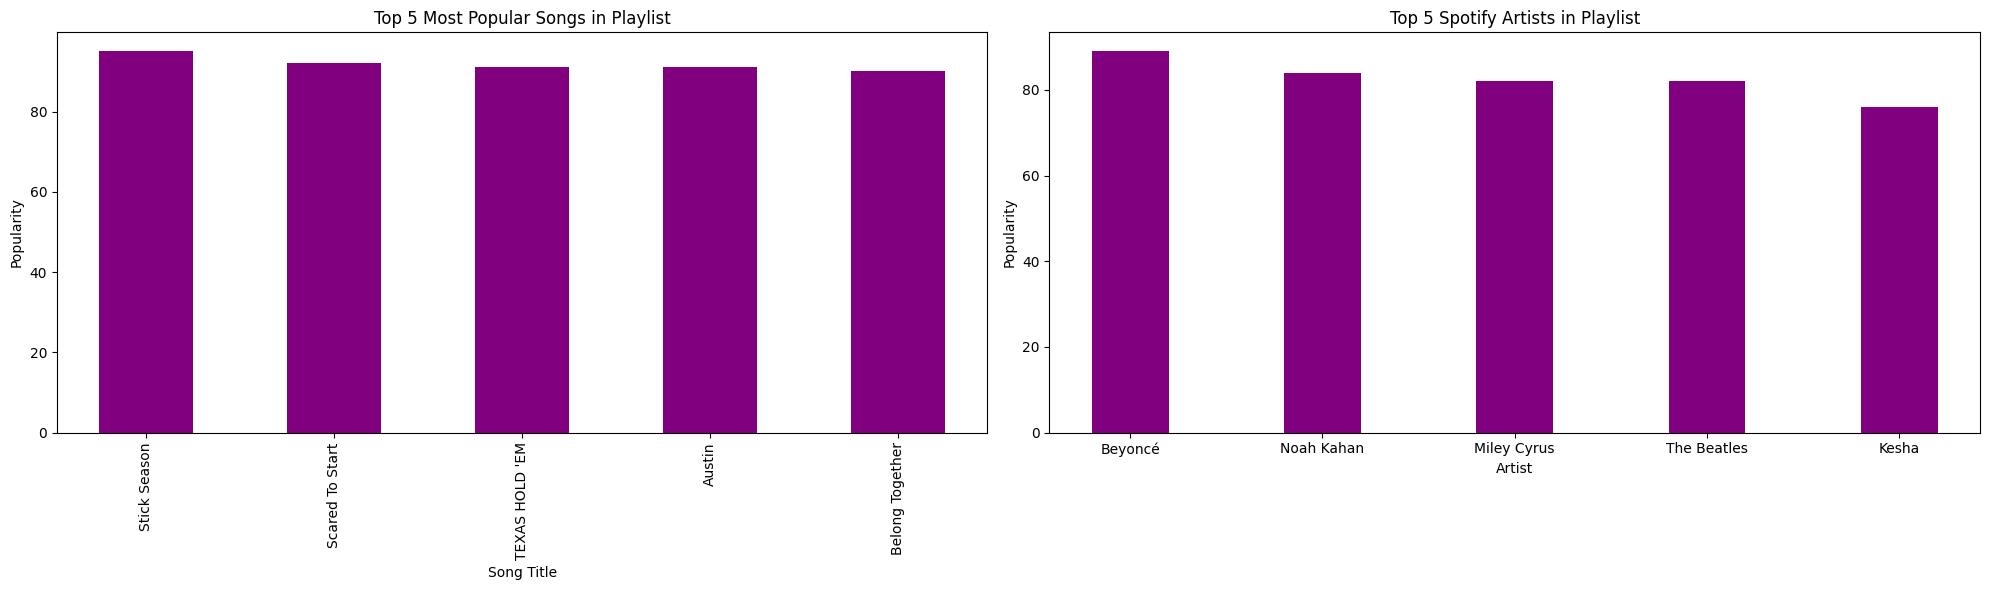

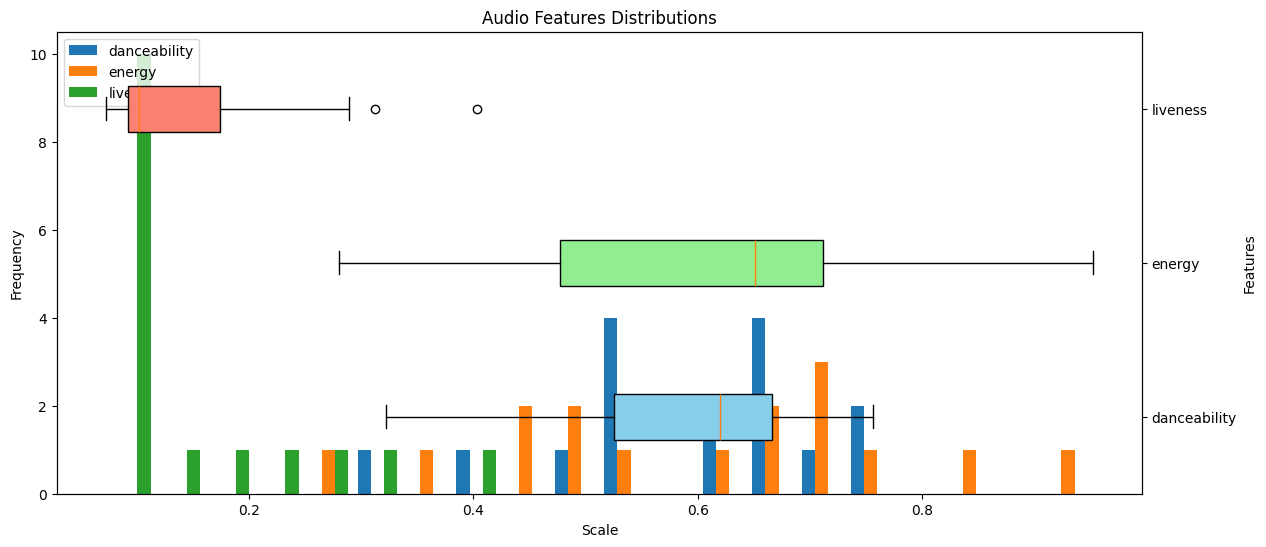

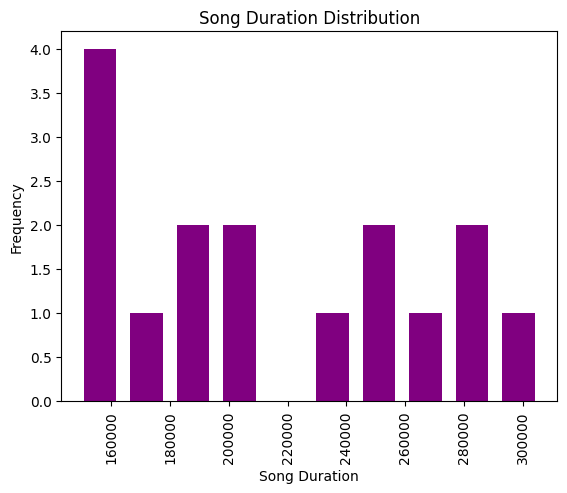

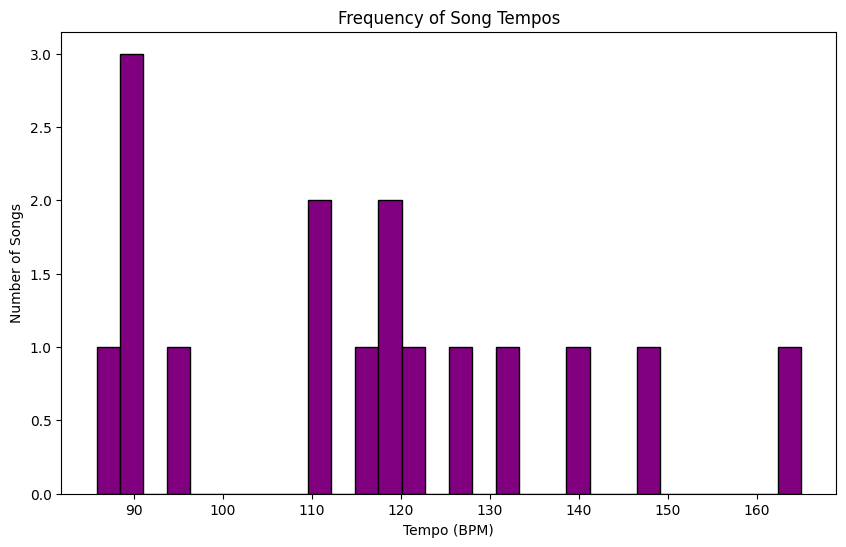

3.54 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit -n 1 playlist_analyzer()